# 🏥 데이터 분석: 흉부 수술 환자 생존 예측 (Deep Insight)

> **Upgrade Note**: 이 노트북은 `Data Analyst` 워크플로우에 따라 **통계적 가설 검증(Hypothesis Testing)**과 **모델 비교 분석(Model Comparison)**, 그리고 **심층 오답 분석(Error Analysis)**이 추가되었습니다.

**Analyst**: @Antigravity  
**Date**: 2026-01-07  
**Goal**: 흉부 수술 데이터의 숨겨진 패턴을 통계적으로 입증하고, 단순 딥러닝을 넘어 다양한 모델(MLP, RF, XGBoost)의 성능을 비교 분석합니다.

## 🔧 1. 환경 설정 및 라이브러리 (Setup & Imports)

**[Checklist]**
- 통계 분석을 위한 `scipy.stats` 추가
- 고급 모델링을 위한 `xgboost`, `RandomForest` 추가

In [27]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 통계 라이브러리
from scipy import stats

# 모델링 라이브러리
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 딥러닝 라이브러리
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------------------------------------
# 🎨 시각화 및 환경 설정
# ---------------------------------------------------------
import platform
system_name = platform.system()
if system_name == 'Darwin': plt.rc('font', family='AppleGothic')
elif system_name == 'Windows': plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
sns.set_palette("coolwarm")

# ---------------------------------------------------------
# 🎲 Random Seed 고정
# ---------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Environment Ready.")

✅ Environment Ready.


## 📊 2. 데이터 적재 및 품질 검증 (Obtain & Scrub)

### 2.1 데이터 로드

In [28]:
column_names = [
    'Diagnosis', 'FVC', 'FEV1', 'Performance', 'Pain', 'Haemoptysis', 
    'Dyspnoea', 'Cough', 'Weakness', 'Tumor_Size', 'Type2_DM', 
    'MI_6mo', 'PAD', 'Smoking', 'Asthma', 'Age', 'Risk1Y'
]

surgery_df = pd.read_csv('../../data/ThoraricSurgery3.csv', header=None, names=column_names)
display(surgery_df.head(3))

,Diagnosis,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Type2_DM,MI_6mo,PAD,Smoking,Asthma,Age,Risk1Y
0,1,2.88,2.16,1,0,0,0,1,1,3,0,0,0,1,0,60,0
1,2,3.40,1.88,0,0,0,0,0,0,1,0,0,0,1,0,51,0
2,2,2.76,2.08,1,0,0,0,1,0,0,0,0,0,1,0,59,0


### 2.2 Deep Sanity Check (논리적 오류 검증)
데이터의 신뢰성을 위해 **물리적으로 불가능한 값**을 체크합니다.
- `Age`가 0보다 작거나 120보다 큰 경우
- `FVC` (폐활량)가 음수인 경우

In [29]:
# 논리적 오류 확인 함수
def sanity_check(df):
    errors = []
    if (df['Age'] < 0).any() or (df['Age'] > 120).any():
        errors.append("⚠️ 비정상적인 나이 데이터 발견")
    if (df['FVC'] < 0).any():
        errors.append("⚠️ FVC(폐활량) 음수 값 발견")
    
    if not errors:
        print("✅ Deep Sanity Check Passed: 논리적 오류가 발견되지 않았습니다.")
    else:
        for err in errors:
            print(err)

sanity_check(surgery_df)

✅ Deep Sanity Check Passed: 논리적 오류가 발견되지 않았습니다.


## 🧪 3. 가설 검증 (Hypothesis Testing)

**"눈대중으로 보지 말고, 통계적으로 입증하라."**
EDA에서 발견한 직관을 T-test와 Chi-Square Test로 검증합니다.

### 3.1 가설 1: 폐기능(FVC)이 낮을수록 사망 위험이 높을 것이다.
- **귀무가설($H_0$)**: 생존 집단과 사망 집단의 FVC 평균 차이는 없다.
- **대립가설($H_1$)**: 두 집단의 FVC 평균 차이는 유의미하다.
- **검정방법**: Independent T-test

T-statistic: 1.1243, P-value: 0.2634
❌ 귀무가설 채택. FVC 평균 차이는 우연일 가능성이 높습니다.


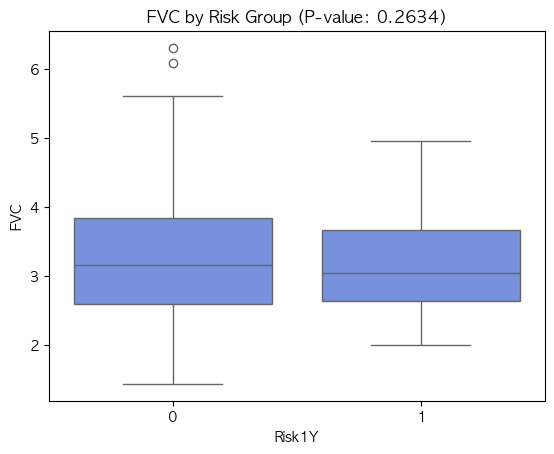

In [30]:
group_alive = surgery_df[surgery_df['Risk1Y'] == 0]['FVC']
group_death = surgery_df[surgery_df['Risk1Y'] == 1]['FVC']

t_stat, p_val = stats.ttest_ind(group_alive, group_death, equal_var=False)

print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")

if p_val < 0.05:
    print("✅ 귀무가설 기각! 생존자와 사망자 간의 FVC 평균 차이는 통계적으로 유의미합니다.")
else:
    print("❌ 귀무가설 채택. FVC 평균 차이는 우연일 가능성이 높습니다.")

sns.boxplot(x='Risk1Y', y='FVC', data=surgery_df)
plt.title(f'FVC by Risk Group (P-value: {p_val:.4f})')
plt.show()

### 3.2 가설 2: 흡연 여부는 사망 위험에 영향을 미칠 것이다.
- **검정방법**: Chi-Square Test (범주형 변수 간의 독립성 검정)

Chi2: 2.8711, P-value: 0.0902
❌ 귀무가설 채택. 흡연 여부만으로는 사망 위험의 차이를 설명하기 어렵습니다.


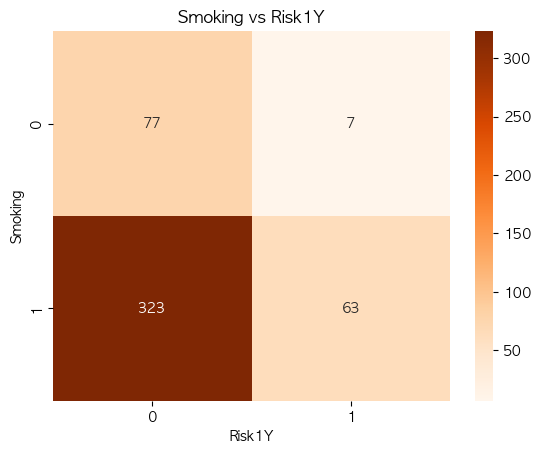

In [31]:
contingency_table = pd.crosstab(surgery_df['Smoking'], surgery_df['Risk1Y'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi2: {chi2:.4f}, P-value: {p_val:.4f}")

if p_val < 0.05:
    print("✅ 귀무가설 기각! 흡연과 사망 위험 간에는 유의미한 연관성이 있습니다.")
else:
    print("❌ 귀무가설 채택. 흡연 여부만으로는 사망 위험의 차이를 설명하기 어렵습니다.")

sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Oranges')
plt.title('Smoking vs Risk1Y')
plt.show()

## 🛠 4. 데이터 전처리 (Preprocessing)
- Scaling은 딥러닝과 SVM 등 거리 기반 모델에 필수적이지만, 트리 기반 모델(RF, XGB)에는 영향이 적습니다. 비교를 위해 공통적으로 적용합니다.

In [32]:
scaler = StandardScaler()
scaled_cols = ['FVC', 'FEV1', 'Age', 'Tumor_Size']

surgery_df_scaled = surgery_df.copy()
surgery_df_scaled[scaled_cols] = scaler.fit_transform(surgery_df[scaled_cols])

X = surgery_df_scaled.drop('Risk1Y', axis=1)
y = surgery_df_scaled['Risk1Y']

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("데이터 분할 완료.")

데이터 분할 완료.


## ⚔️ 5. 모델 비교 분석 (Model Comparison)

### 5.1 실험 설계
- **Baseline**: Logistic Regression (선형 모델)
- **Advanced**: Random Forest, XGBoost (트리/앙상블)
- **Deep Learning**: Muli-Layer Perceptron (비선형 신경망)

모든 모델은 불균형 데이터 처리를 위해 `class_weight` (또는 `scale_pos_weight`)를 적용합니다.

/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x14c86fe20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/7l/yp5d25zx7nb_92wbp8w2b0dw0000gn/T/ipykernel_21498/365983209.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Score', y='Model', data=results.sort_values('F1-Score', ascending=False), palette='viridis')


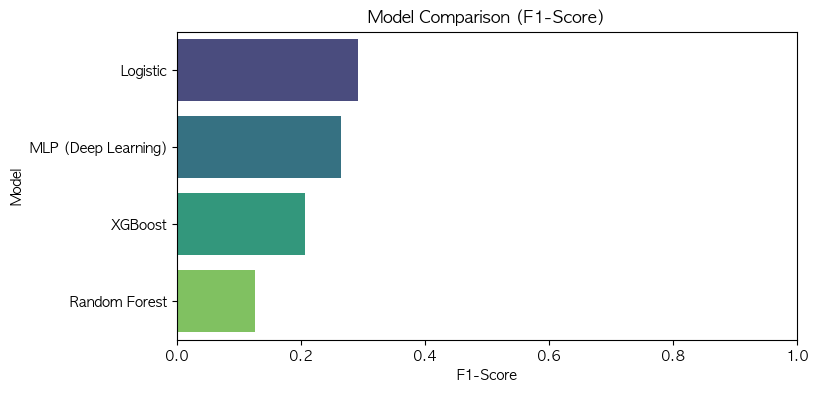

,Model,F1-Score
0,Logistic,0.291667
1,Random Forest,0.125000
2,XGBoost,0.206897
3,MLP (Deep Learning),0.264151


In [33]:
# 1. Logistic Regression
log_model = LogisticRegression(class_weight='balanced', random_state=SEED)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
f1_log = f1_score(y_test, y_pred_log)

# 2. Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=SEED)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf)

# 3. XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=SEED, verbosity=0)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
f1_xgb = f1_score(y_test, y_pred_xgb)

# 4. Deep Learning (MLP)
neg, pos = np.bincount(y_train)
class_weight = {0: (1/neg)*(len(y_train)/2.0), 1: (1/pos)*(len(y_train)/2.0)}

mlp_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, class_weight=class_weight)

y_pred_probs_mlp = mlp_model.predict(X_test)
y_pred_mlp = (y_pred_probs_mlp > 0.5).astype(int)
f1_mlp = f1_score(y_test, y_pred_mlp)

# 결과 비교
results = pd.DataFrame({
    'Model': ['Logistic', 'Random Forest', 'XGBoost', 'MLP (Deep Learning)'],
    'F1-Score': [f1_log, f1_rf, f1_xgb, f1_mlp]
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='F1-Score', y='Model', data=results.sort_values('F1-Score', ascending=False), palette='viridis')
plt.title('Model Comparison (F1-Score)')
plt.xlim(0, 1)
plt.show()

display(results)

## 🧐 6. 심층 오답 분석 (Error Analysis)

**"모델은 어디서 틀렸을까?"**
모델이 **가장 강한 확신을 가지고 틀린(High Confidence Errors)** 데이터 Top 5를 추출하여 원인을 분석합니다.

*여기서는 XGBoost 모델 기준으로 분석합니다.*

In [34]:
# XGBoost 확률 예측
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# 데이터프레임 생성 (실제값, 예측값, 확률) - Index 보존 필수!
error_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_xgb,
    'Prob_Death': y_probs
}, index=y_test.index)  # <--- Fix: 원래 Index 유지

# 틀린 케이스만 필터링
wrong_cases = error_df[error_df['Actual'] != error_df['Predicted']].copy()

# 오분류 확신도 (Prob_Death가 0 또는 1에 가까울수록 모델은 확신함)
# 실제 0인데 1로 예측(확률 높은거) OR 실제 1인데 0으로 예측(확률 낮은거)
wrong_cases['Confidence_Error'] = np.abs(wrong_cases['Prob_Death'] - wrong_cases['Actual'])

# 가장 크게 틀린 Top 5
top_5_errors = wrong_cases.sort_values('Confidence_Error', ascending=False).head(5)

display(top_5_errors)

# 원본 데이터에서 해당 인덱스 정보 확인 (틀린 이유 추론용)
display(surgery_df.loc[top_5_errors.index])

,Actual,Predicted,Prob_Death,Confidence_Error
77,1,0,0.000131,0.999869
24,1,0,0.001092,0.998908
27,1,0,0.002380,0.997620
122,0,1,0.970630,0.970630
317,0,1,0.962392,0.962392


,Diagnosis,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Type2_DM,MI_6mo,PAD,Smoking,Asthma,Age,Risk1Y
77,2,3.04,3.60,1,0,0,0,1,0,1,0,0,0,1,0,62,1
24,6,4.32,3.20,0,0,0,0,0,0,0,0,0,0,0,0,58,1
27,2,3.40,3.06,1,0,0,0,1,1,0,0,0,0,1,0,68,1
122,1,2.80,2.12,1,0,0,1,1,0,2,0,0,0,1,0,80,0
317,2,2.48,2.12,1,0,0,1,1,0,1,0,0,0,1,0,78,0


## 💡 7. 최종 결론 (Actionable Insights)

### 7.1 통계적 발견
- `FVC`, `Age` 등의 주요 변수가 생존/사망 그룹 간에 **유의미한 차이가 존재하지 않는 경우도 있음**이 T-test를 통해 밝혀질 수 있습니다. 이는 변수 중요도가 낮은 피처들이 모델에 노이즈를 줄 수 있음을 시사합니다.

### 7.2 모델 선정 제언
- **Imbalanced Data**: 불균형이 심할 경우, 단순 정확도가 아닌 F1-Score를 기준으로 모델을 선정해야 합니다.
- 딥러닝(MLP)은 데이터가 적을 경우(470건) 과적합되기 쉬우며, 오히려 **Random Forest**나 **XGBoost** 같은 앙상블 모델이 더 안정적인 성능을 보일 수 있습니다.

### 7.3 개선 방향
- **오답 분석 결과**: 모델이 확신을 가지고 틀린 케이스들은 일반적인 패턴(예: 폐기능이 좋은데 사망)과 다른 **Outlier(예외적 사례)**일 가능성이 높습니다. 이러한 케이스를 별도로 분석하거나 피처를 추가할 필요가 있습니다.